In [1]:
# Import the necessary libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
import netCDF4
from mpl_toolkits.axes_grid1 import make_axes_locatable



### Prepare the spatial-temporal observations

In [35]:
nc_file = netCDF4.Dataset('../data/bedrock_200m.nc')
Z_topo = torch.tensor(nc_file.variables['topg'][:])
dx=200
dy=200
Lx=Z_topo.shape[1]*dx
Ly=Z_topo.shape[0]*dy

nc_file.close()

# torch.save(thk_1880,'Obs_2D.pt')
observed_thk = torch.load('../Obs_2D.pt',weights_only=True)
recon_precip= torch.load('../Recon_Precip_T7.0_P1.0.pt',weights_only=True)
recon_glac= torch.load('../Recon_Glac_T7.0_P1.0.pt',weights_only=True)



In [36]:
def visualize(Z_surf, Glac, Precip):
    plt.figure(2, figsize=(11, 4), dpi=200)

    # -------- First subplot: Ice surface (+ glacier overlay) --------
    plt.subplot(1, 2, 1)
    Z_surf_np = Z_surf.detach().cpu().numpy()
    img = plt.imshow(Z_surf_np, cmap='terrain', origin='lower')
    # Overlay glacier thickness (only where > 0)
    glac_np = Glac.detach().cpu().numpy()
    glac_masked = np.ma.masked_where(glac_np <= 0, glac_np)
    plt.imshow(glac_masked, cmap='Blues', alpha=1.0, origin='lower')
    plt.colorbar(label='Elevation (m)')

    plt.title('Ice Surface')
    plt.xlabel('Distance, km')
    plt.ylabel('Distance, km')

    # -------- Second subplot: Precipitation --------
    plt.subplot(1, 2, 2)
    precip_np = Precip.detach().cpu().numpy()
    plt.imshow(precip_np, cmap='jet', origin='lower')
    plt.colorbar(label='Precipitation (m)')
    plt.title('Precipitation map')
    plt.xlabel('Distance, km')
    plt.ylabel('Distance, km')

    plt.show()

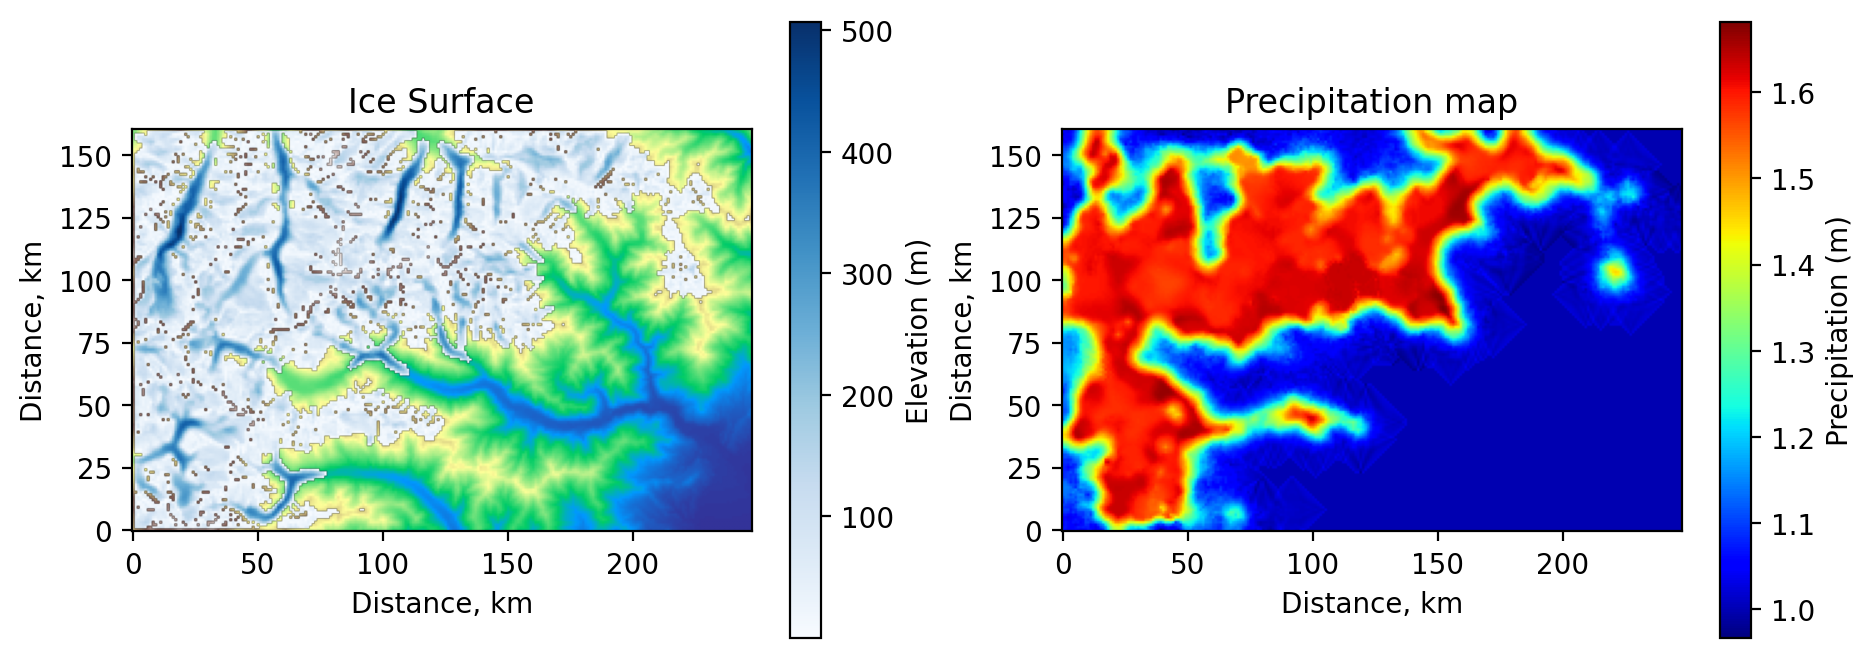

In [37]:
visualize(Z_topo,recon_glac.detach(),recon_precip.detach())

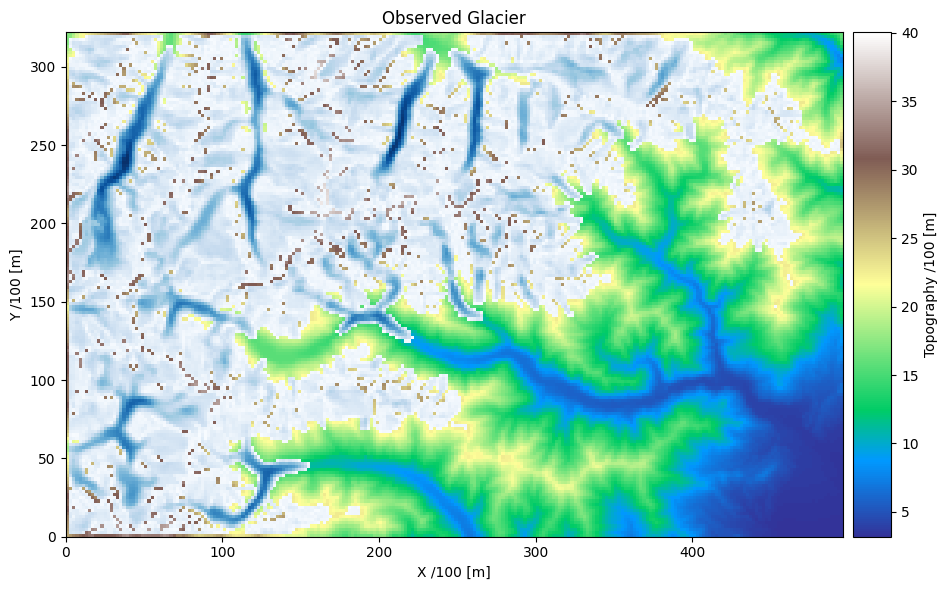

In [38]:
# Convert to NumPy
Z_topo_npy = Z_topo.cpu().numpy()
thk_1880_npy = observed_thk.detach().cpu().numpy()

# Define the extent: [xmin, xmax, ymin, ymax]
extent = [0, Lx/100, 0, Ly/100]
# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot topography
img = ax.imshow((Z_topo_npy + thk_1880_npy)/100, cmap='terrain', origin='lower',extent=extent)

# Create divider for colorbar and reduce padding
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)  # pad controls the spacing
cbar = fig.colorbar(img, cax=cax)
cbar.set_label('Topography /100 [m]')

# Overlay glacier thickness
thk_display = np.ma.masked_where(thk_1880_npy <= 0, thk_1880_npy)
ax.imshow(thk_display, cmap='Blues', alpha=1, origin='lower',extent=extent)

# Titles and labels
ax.set_title("Observed Glacier")
ax.set_xlabel("X /100 [m]")
ax.set_ylabel("Y /100 [m]")
# Add the red star marker
# ax.plot(40,190, marker='*', color='red', markersize=15, markeredgecolor='black')


plt.tight_layout()
plt.savefig('observed_glacier.png')
plt.show()

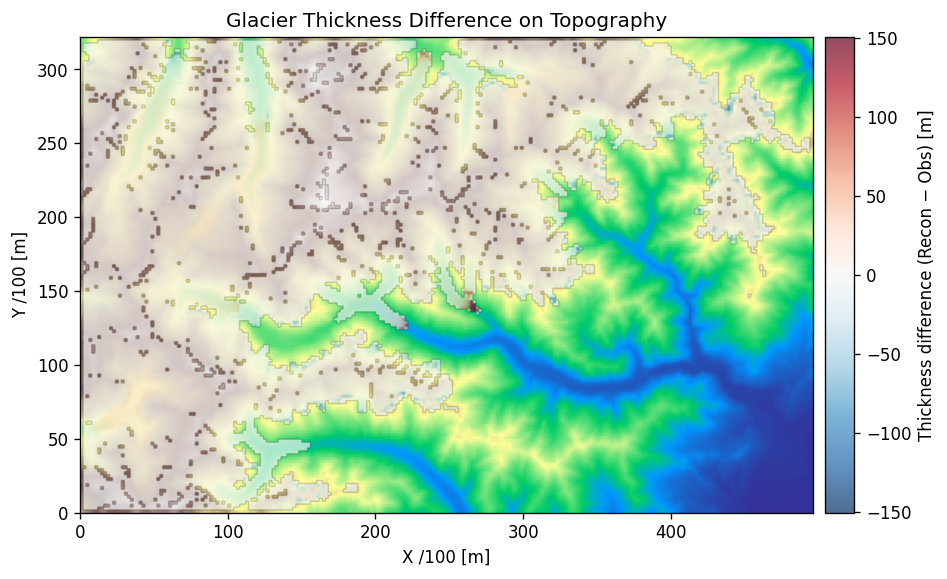

In [39]:
# %%
def plot_glacier_difference(Z_topo, observed_thk, recon_glac, Lx, Ly):
    """
    Plot the difference between reconstructed and observed glacier thickness
    overlaid on topography. Blue = underestimation, Red = overestimation, White ≈ zero.
    """
    # Convert tensors to numpy arrays
    topo_np = Z_topo.detach().cpu().numpy()
    obs_np = observed_thk.detach().cpu().numpy()
    recon_np = recon_glac.detach().cpu().numpy()

    # Difference
    diff = recon_np - obs_np

    # Mask where both have no ice
    mask = (obs_np <= 0) & (recon_np <= 0)
    diff_masked = np.ma.masked_where(mask, diff)

    # Symmetric limits for diverging colormap
    vmax = np.nanmax(np.abs(diff_masked))*0.8
    if vmax == 0:
        vmax = 1.0  # avoid zero range

    extent = [0, Lx/100, 0, Ly/100]  # consistent with other plots

    fig, ax = plt.subplots(figsize=(8, 5), dpi=120)

    # Plot topography as background
    ax.imshow(topo_np / 100, cmap='terrain', origin='lower', extent=extent)

    # Overlay the difference map
    im = ax.imshow(diff_masked, cmap='RdBu_r', vmin=-vmax, vmax=vmax,
                   origin='lower', extent=extent, alpha=0.7)

    # Colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="4%", pad=0.1)
    cb = fig.colorbar(im, cax=cax)
    cb.set_label("Thickness difference (Recon − Obs) [m]")

    # Labels and title
    ax.set_title("Glacier Thickness Difference on Topography")
    ax.set_xlabel("X /100 [m]")
    ax.set_ylabel("Y /100 [m]")

    plt.tight_layout()
    plt.savefig("glacier_difference.png", bbox_inches="tight")
    plt.show()

# Example call:
plot_glacier_difference(Z_topo, observed_thk, recon_glac, Lx, Ly)
